# Model Evaluation (mostly, for regression, but w/ some more general points)

In [10]:
import math
import random 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

def pretty_print_linear(coefs, intercept, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(1,1+len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return "%6.3f"%intercept+" + " +" + ".join("%6.3f * %s" % (coef, name)
                                   for coef, name in lst)

This notebook is going to cover a bunch of things related to model evaluation for regression, with a specific focus on linear and polynomial regression:

1. Coefficient interpretation - one part of evaluation is looking at what our model actually learned. We're going to touch on this, but only for linear regression, here.
2. Making predictions - when we have a model we want to evaluate, we have to actually know what predictions it is making! 
3. Identifying some models to compare to - it is fun to think about how well a single model does, but often it is hard to judge a model solely on it's own performance (we'll discuss why below).
4. Evaluating models when we know the true data generating process - in the real world, we don't. But simulating cases where we do can teach us a lot! We can then look at the true bias and variance of the model!
5. Evaluating models when we *don't* know the true data generating process - here, we have to rely on empirical estimates of error, but we have to be really careful when we do that. We'll introduce some main ideas here, and continue this in future lectures

# Interpreting coefficients for linear regression

One important thing we might want to know from a given linear regression model is how any given feature relates to our prediction.  We can do this by analyzing the **regression coefficients**. 


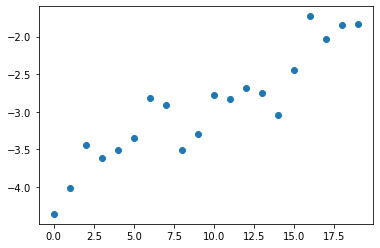

In [11]:
#generate some data
x = np.arange(20)
w = np.array([-3.8,0.11])
y = w[0] + w[1]*x
sigma2 = 0.1
y = y + np.random.normal(0,np.sqrt(sigma2),x.shape[0])
plt.scatter(x,y)

In [12]:
def calculateSquaredLoss(X,y,w):
    X1 = np.hstack([np.ones([X.shape[0],1]),X])
    ypred = np.dot(X1,w)
    return 0.5*np.sum(np.power(ypred - y,2))

In [13]:
from sklearn.linear_model import LinearRegression
# fit model - note that LinearRegression's fit function adds the intercept by default
x = np.transpose(np.reshape(x,[1,len(x)]))
y = np.transpose(np.reshape(y,[1,len(y)]))
lr = LinearRegression()
lr.fit(x,y)
print(pretty_print_linear(lr.coef_,lr.intercept_))

-4.005 +  0.112 * X1


The key thing to remember is that **a linear regressioncoefficient tells us how much our modeled outcome changes with a one-unit change in $x$.** 

If we have multiple predictors, i.e. ${\bf x}$, then we append to this above statement **holding all other predictors fixed**.

### Some considerations in interpreting coefficients

#### Correlation is not causation
Regression models do not care what the $x$ and $y$ are. Just because $x$ predicts $y$, then, isn't a causal statement, because it is equally valid to flip the model around and say that $y$ causes $x$. There are at least two ways to get to causation: 1) to use *social* theory, and 2) to use causal inference. Both come with many assumptions, we will discuss this later in the semetser.
   
#### Knowing a relationship is "real"
As we discuss elsewhere in class, our model learns parameters based on training data that is simply a sample from a population. Thus, one reasonable question to ask is, *how do I know if the relationship between my $x$ and my $y$, as measured by the regression coefficients/parameters, is "real"*? There are many ways to answer this question. Perhaps the most obvious and well-established is to place a confidence interval on your parameter estimate using statistical inference. As always [StatQuest has a nice explanation of this](https://www.youtube.com/watch?v=hokALdIst8k&list=PLblh5JKOoLUIzaEkCLIUxQFjPIlapw8nU&index=7&ab_channel=StatQuestwithJoshStarmer). We will discuss this in more detail at some point later in class. But another approach to thinking about this for ML, where we often care mainly about prediction, is that this relationship is "real" if it is useful in making predictions. We're going to stick with that one for now.


#### Interpretation is based on variable scale

Your interpretation of your features depends on **the scale of both $x$ and $y$**. Sometimes, to make interpretation easier, you may want to *rescale* your input, *or* your outputs.  Some points to remember:

**Assuming you have an intercept in your model, and no interaction terms, rescaling changes your interpretation of a linear model, but not the actual fit.** [Here is a useful explanation of why](https://stats.stackexchange.com/questions/32649/some-of-my-predictors-are-on-very-different-scales-do-i-need-to-transform-them).


In [42]:
data_size = 500
data = pd.DataFrame({"covid_deaths_per_person_in_state": [random.gauss(.01,1) for _ in range(data_size)],
                     "covid_cases_per_state": [random.gauss(1000,10) for _ in range(data_size)]
                    })
data['local_news_covid_articles'] = data.covid_deaths_per_person_in_state + data.covid_cases_per_state

mod = LinearRegression(fit_intercept=False).fit(data[['covid_deaths_per_person_in_state',
                                                      'covid_cases_per_state']], 
                                                data.local_news_covid_articles)
mod.coef_

array([1., 1.])

**Exercise**: In this example, what is more important, deaths or cases? Do our regression coefficients tell us that?

**Changing the scale of your $y$ changes your interpretation as well!** We discussed an example in class, and there is one on your programming assignment. There's some useful resources on the internet for this point if you want to learn more, in particular, [here is one useful exploration for how to interpret linear coefficients with a logged outcome](https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/).

Finally, **we will see models where rescaling/standardizing your variables is *critical* for model performance. Linear regression is not one of them, but other regression and classification approaches definitely are impacted by the scale of your input variables. More on this later!**

#### Interpretation is based on what your null model represents!

The most obvious place this comes up is in the context of using categorical variables in your regression. 

Consider a regression model where we are trying to predict the amount of water you drink in a day. We have one feature, whether or not you have exercised:



In [47]:
data = pd.DataFrame({"exercised" : random.choices(['yes','no'], k=500)})

## Mini-quiz ... what is this code doing?
data['water'] = 10 + 3*(data.exercised == "yes").astype(int)

OK! Let's try to fit that! 

In [50]:
mod = LinearRegression(fit_intercept=False).fit(data[['exercised']], 
                                                data.water)

ValueError: could not convert string to float: 'no'

**Exercise:** What happened?

... OK, let's fix the issue, naively

In [53]:
data['exercised_yes'] = (data.exercised == "yes").astype(int)
data['exercised_no'] = (data.exercised == "no").astype(int)
mod = LinearRegression(fit_intercept=False).fit(data[['exercised_yes','exercised_no']], 
                                                data.water)
mod.coef_

array([13., 10.])

Hmph... that worked, but ... that doesn't match our true function! Note, however, that `13-10 = 3`, which is what our expected result would have been for a single coefficient.

**Exercise: what happened? (don't peek!)**

... note that our regression function as specified is:

$ y = w_0 + w_1*exercised + w_2 no\_exercise + \epsilon$

Now, note that: $exercised = 1 - no\_exercise$, so we can rewrite that as:
 
$ y = w_0 + w_1*exercised + w_2 - w_2 exercised + \epsilon $, and so:

$ y = (w_0 + w_2) + (w_1-w_2) exercised + \epsilon$

**Exercise:** How many $w_1$ and $w_2$s can we find that solve this equation?

Note: the closed form solution wouldn't even have worked here! (Because we can't invert this matrix). But `sklearn` still gives us an output! [Here](https://stats.stackexchange.com/questions/240573/how-does-numpy-solve-least-squares-for-underdetermined-systems) is an explanation of why, you're not responsible for understanding that explanation, though.

---

OK, so, now we know that we should arbitrarily pick either `yes` or `no` and *drop* that column. Here, it makes sense to drop `no`, although in many cases this choice is arbitrary.  Having done so, our model becomes:

$ y = w_0 + w_1*exercised + \epsilon$

**Exercise:** What does $w_0$ now represent?

---

Finally, note that all of this logic extends to categorical variables, which we "one-hot encode" too!


**Aside: not all transformations are linear rescaling**. **Exercise:** What is an example of a transformation that might help us make predictions?

# Making predictions with a model

To evaluate our model's predictions, we have to be able to actually make those predictions. At a high level, we make predictions by simply subbing in the $x$ value in the test data into our trained model.  That is, assume we have trained a model $f_{\hat{w}}$ (using the notation in the [UW course](https://courses.cs.washington.edu/courses/cse416/18sp/)). Then to make a prediction on a test point, we evaluate $f_{\hat{w}}$ at $x$, i.e. we compute $f_{\hat{w}}(x)$.

# Finding some models to compare

It can in many cases be useful to evaluate a single model, but typically it is very hard to know how well you are making predictions if you look at one and only one model combined with one and only one set of features. **Exercise: why?**

In class, we generalized regression, following [the end of Chapter 1 from Hunter Schafer's book](https://cse-stat-416-book.vercel.app/chapters/linear_regression). You are responsible for understanding this generalized equation.

At a high level, though, there are a few different things we can do to try to make different/better predictions:
1. Change our features - we can try to collect more features, or manipulate/transform the ones we have
2. Change our model - increase or decrease the complexity of our model
3. Change our optimization proceedure - if we have a complex surface for our loss function, doing better optimization can 

Note that, as we discussed in class, 1 and 2 are tightly intertwined, in that some models (e.g. polynomial regression) implicitly "add" to our features


# Actually comparing models ... when we know the truth
# !!!!!!!! <span style="color:red">Disclaimer: this is a modified version of Hunter Schafer's demo [here](https://courses.cs.washington.edu/courses/cse416/18sp/notebooks/html/bias-variance.html)</span> !!!!!


We're going to do this "actual model comparison" in two ways. In the first, we're going to assume we **know the true function**. If we know the true function, we can assess the bias/variance tradeoff of our model by direct evaluation of model bias and variance!

In this section, we are going to:

- Practice understanding the bias/variance tradeoff
- Practice fitting some models in `sklearn`
- Learn the value of simulation

## Reminder: the high-level goal

One way to think about ML is, as we have discussed, in terms of trying to estimate (conditional probability) functions. A good way to think about this is to think about there being some **true function** `f` that we want to learn.

Sadly, we don't know the functional form (linear? polynomial?) *or* the parameters of the model (in terms of what we have seen so far, what are the `w`s?).

Our goal in ML is to learn `f` given only **one random training set** that gives us some `x` and some `y`, where `y` is, as noted further below, the output of `f(x)` plus some irreducible noise.  

**Exercises** 
- Where might that noise come from?
- What if that noise isn't random?

# Where does error come from?

In lecture, we discussed how the source of error in our estimation of `f(x)` using training data comes from one of three places:
* **Irreducible Error:** The noise from the dataset. In our model, `y_i = f(x_i) + epsilon_i`, and it is hopeless to learn the `epsilon_i` since its random and does not depend on the input
* **Bias:** How much our expected learned model (expectation is over all possible training sets) differs from the underlying model.
* **Variance:** How dependent the learned model is on the particular dataset it was learned on. If slightly changing the dataset leads to a huge change in learned model, then variance is high.

Remember this picture for bias/variance: 


In [107]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://miro.medium.com/max/384/1*dxzjw6RMg6myHwk1HEKdKQ.png",
     width=400)


There is a fundamental tradeoff between bias and variance that depends on how complex your model is. Very simple models (with what we've seen so far, models with few parameters) have high bias since your true function is usually not constant, but have low variance since they generally don't have the complexity to fit the noise of the specific dataset you got. Very complex models (high degree polynomials) have low bias since you can get a descent approximation of the true function **in expectation**, but have high variance since they have the capabilities of fitting the noise in the data.

This section has some code examples to demonstrate how this bias variance tradeoff occurs with different model complexities using synthetic data.`

## Step 1 - Define our "true function" we're going to try to learn

In [14]:
MIN_X = -1
MAX_X = 6

def f(x):
    """
    True function f(x) (unknown to us)
    """
    return 2 * x - 1.4 * x ** 2 + .2 * x ** 3


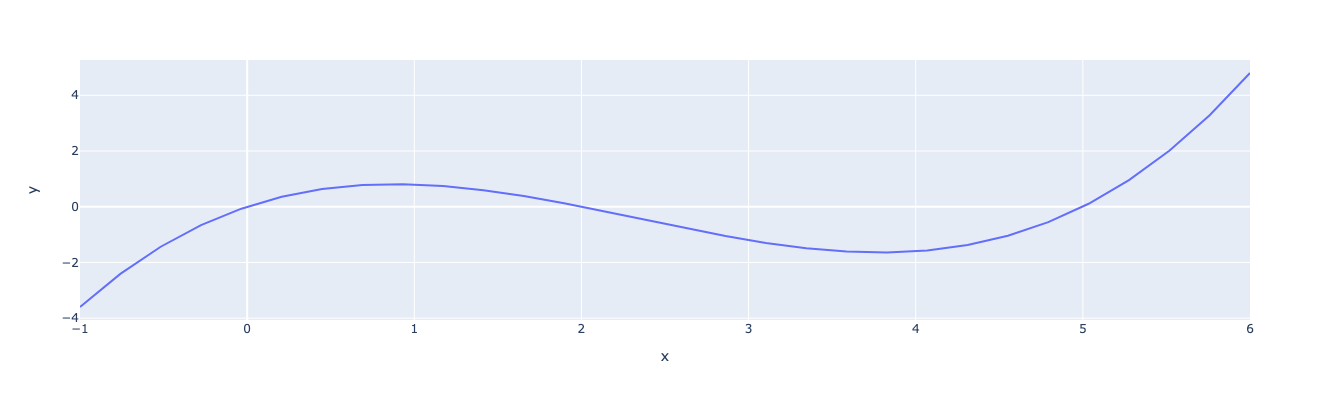

In [15]:
px.line(pd.DataFrame({"x": np.linspace(MIN_X,MAX_X, 30), 
                      "y" : [f(x) for x in np.linspace(MIN_X,MAX_X, 30)]}),
       x="x",y="y",
       height=400,width=400)

## Step 2 -  Define functions to simulate random training dataset

The `generate_data` function below will generate `x` values uniformly at random in [`min_x`, `max_x`] and then assign the values using the function `f` and Gaussian noise with mean 0 and variance `noise_sd`. 

In [16]:


def generate_data(n,min_x=0,max_x=1, noise_sd = .1):
    """
    Creates and returns a SFrame with n randomly drawn examples
    """
    xs = [random.uniform(min_x, max_x) for _ in range(n)]   # generate n numbers uniform at random from [0, 1]
    ys = [f(x) + random.gauss(0, noise_sd) for x in xs] # evaluate f at each x and add Gaussian noise (mean=0, variance=.1)
    return pd.DataFrame({'x': xs, 'y': ys})


def polynomial_features(data, col, deg):
    """
    Given a dataset, creates a polynomial expansion of the input with 
    the given name to the given degree.
    
    Returns the dataset and the list of column names
    """
    data_copy = data.copy()
    if deg == 0:
        data_copy[col + '0'] = 0
        columns = [col + '0']
    else:
        columns = []
        for i in range(1, deg + 1): # +1 to include deg
            col_name = col + str(i)
            data_copy[col_name] = data_copy[col] ** i
            columns.append(col_name)
        
    return data_copy, columns

Below is an example dataset we might observe. 

In [17]:
data = generate_data(n=50)
data, columns = polynomial_features(data, 'x', deg=3)
print(columns)
data.head()

['x1', 'x2', 'x3']


x         y        x1        x2        x3
0  0.242160  0.409650  0.242160  0.058641  0.014201
1  0.341757  0.602137  0.341757  0.116798  0.039916
2  0.472779  0.671901  0.472779  0.223520  0.105676
3  0.829565  0.760769  0.829565  0.688178  0.570889
4  0.417905  0.494490  0.417905  0.174645  0.072985

If you run it multiple times, you would most likely get different values. **Exercise: Why?**

This feels kind of unrealistic - we only have one training dataset! True. But let's say our training dataset is a set of tweets sent today, and we train a model to predict number of retweets. There's a lot of randomness in that sample, and if we sampled again tomorrow, it would likely lead to a (slightly) different model!

## Step 3 - Learn model(s) based on (a set of) training datasets

The following function will learn some given number of models using random samples from our training set. **Exercise: how are we getting those random samples?**

This is technique of approximating getting new datasets from the underlying distribution with only our one dataset is known as *resampling*. 

We will use each random (re)sample of our training set to train a model

In [18]:

def learn_models(data, features, num_models):
    """
    Trains num_models models on random subsets of the given data. 
    Returns the list of learned models.
    """
    models = []
    for i in range(num_models):
        # get a random sample of the datat
        random_sample_from_X, _, random_sample_from_y, _=  train_test_split(data[features].values,data.y.values,test_size=0.4)
        model = LinearRegression().fit(random_sample_from_X,random_sample_from_y)
        models.append(model)
    return models


In [19]:
models = learn_models(data, columns, 3)
for mod in models:
    print(pretty_print_linear(mod.coef_,mod.intercept_))

-0.078 +  2.713 * X1 + -2.887 * X2 +  1.146 * X3
 0.099 +  1.294 * X1 + -0.106 * X2 + -0.512 * X3
 0.001 +  1.884 * X1 + -0.772 * X2 + -0.317 * X3


These models are all different, even though they're estimating the same `f`!!! 

**Exercises**
- Why are they different?
- What is one change we could make to `learn_models` to make them all (almost) the same?
- Will a model in this hypothesis class be able to correctly estimate `f` if `f(x) =  2 * x - 1.4 * x ** 2 + .2 * x ** 3 + x**4`?

## Step 4 - Make a bunch of predictions at various values of x

Now, we want to think about how different forms we could specify for our guess at `f` lead to different levels of bias and variance. To do that, we're going to train a bunch of models, and use them all to make predictions at a bunch of values of `x`. Let's call each model $f_{\hat{w}}(x)$, representing the fact that they are all approximations of `f` based on different parameters $\hat{w}$. We're then going to plot the *range* of the predictions across all models to get a sense of variance, and $\mathbb{E_{\hat{w}}}[f_{\hat{w}}(x)]$ to get a sense of the bias.

In [20]:
def find_predictions_range(models, model_degree, num_eval_points, min_x=0, max_x=1):
    """
    Compares the predictions of the given models at num_eval_points between min_x and max_x.
    
    This gives a description of how spread the predictions are at a particular point x. 
    If the predictions are all over the place, then the range of predictions will be high.
    
    Returns:
        * A list of points evaluated (of length num_eval_points)
        * A list of tuples containing information about the predictions at each eval point. 
          Each tuple contains the minimum prediction, mean prediction, and max prediction for that input
          
    """
    new_xs = np.linspace(min_x, max_x, num_eval_points) # just like range, but allows for fractional steps
    new_data = pd.DataFrame({'x': new_xs})
    new_data, columns = polynomial_features(new_data, 'x', model_degree)

    all_predictions = [model.predict(new_data[columns].values) for model in models]
    intervals = []
    for i in range(len(new_xs)):        
        # get predictions from each model for this input i
        preds_i = [preds[i] for preds in all_predictions]
        # find the mean, min, and max
        intervals.append((min(preds_i), np.mean(preds_i), max(preds_i)))
        
    return new_xs, intervals

In [21]:
x, model_pred_intervals = find_predictions_range(models, 3, 10, MIN_X,MAX_X)
print(x)
print("_________")
print(model_pred_intervals[0])

[-1.         -0.22222222  0.55555556  1.33333333  2.11111111  2.88888889
  3.66666667  4.44444444  5.22222222  6.        ]
_________
(-6.823340291037015, -3.317104640622015, -0.7897900273220814)


In [22]:
def plot(data, new_xs, intervals,min_x=0,max_x=1):
    """
    Plots the data and range of predictions to demonstrate the bias and variance of the model
    """
    # magic to separate list of [(low, mean, high)] to list of lows, list of means, list of highs
    lows, means, highs = zip(*intervals)       
    
    # plot the range bands for predictions
    plt.fill_between(new_xs, lows, highs, facecolor='#E8F8F8', edgecolor='#c3e2e2',
                     label='Range of predictions')
    # plot the average predictions (won't perfectly match f because it's an approximation of E_train[hat{f}]
    plt.plot(new_xs, means, color="r", label='Average hat{f}')
    # plot the true f
    plt.plot(new_xs, [f(x) for x in new_xs], color='g', label='True f')
    # plot the datapoints
    plt.scatter(data['x'], data['y'], c='black', s=10, label='Data')

    # modify axis to make it look nice and add label
    axes = plt.gca()
    axes.set_xlim([min_x, max_x])
    axes.set_ylim([data['y'].min() - 0.5, data['y'].max() + 0.5])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

## Step 4 - Run some experiments!

This is the main function to run our experiments. See the cell aftewards how to call it. 

In [23]:
def bias_variance(num_data, num_models, degree_expansions, num_eval_points=200, min_x=0, max_x=1,noise_sd=.1):
    """
    Demonstrates the bias-variance tradeoff for each degree in degree_expansions using 
    one randomly generated dataset of num_dat samples with value some true f(x) + noise.
    
    For each degree, trains num_models models using features up to that degree. It then uses
    those models to make predictions for the num_eval_points between 0 and 1. It records 
    these predictions and visually plots the range of predictions for each x.
    """
    print('Generating data')
    data = generate_data(num_data,min_x,max_x,noise_sd)
    for degree_expansion in degree_expansions:
        print('Evaluating model with degree ' + str(degree_expansion))
        # generate data with 
        data, columns = polynomial_features(data, 'x', degree_expansion)
        models = learn_models(data, columns, num_models)
        new_xs, intervals = find_predictions_range(models, degree_expansion, num_eval_points,min_x,max_x)
        plot(data, new_xs, intervals,min_x,max_x)

Generating data
Evaluating model with degree 0


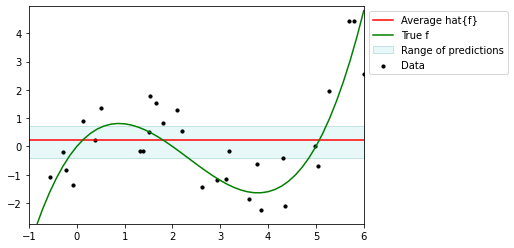

Evaluating model with degree 1


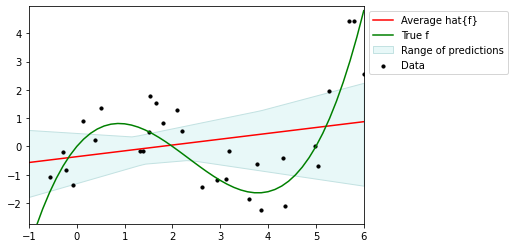

Evaluating model with degree 2


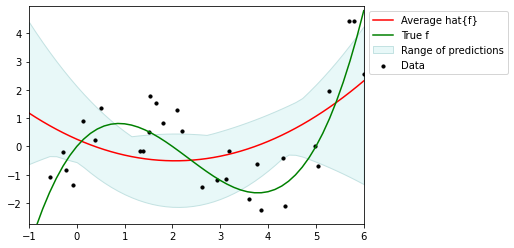

Evaluating model with degree 5


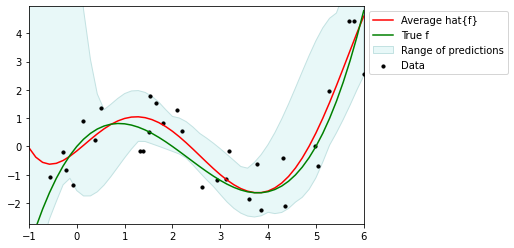

Evaluating model with degree 10


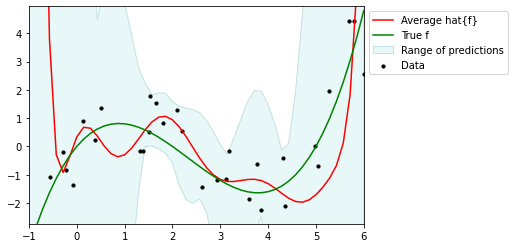

In [24]:
bias_variance(num_data= 30, 
              num_models = 100, 
              degree_expansions = [0, 1, 2, 5, 10], 
              num_eval_points = 50, 
              min_x=MIN_X, 
              max_x=MAX_X, 
              noise_sd=1)

The way to read each of the graphs is:
* The black dots are the datapoints from our one dataset (which was drawn from the underlying distribution)
* The green line is the true function `f`
* The red line is the average prediction at each value x from all of the models trained on random samples of the training dataset. This is an approximation of the expected learned model, but is not perfect. **Exercise: why?**
* The blue region is the range of prediction values over all the learned models for that particular input

**Exercises**
- Which model has the lowest bias? Highest?
- Which model has the lowest variance? Highest?
- Which model is the best? Why?
- What would happen if we change `noise_sd` to be really large?
- What would happen if we change `f` - would the same models still be the best?
- What would happen if we change `num_data` -i.e. increase the size of the dataset?

# Model evaluation without access to the truth

We've already seen some of this stuff in Lecture 4 with our introduction to why we need a train/test split.  But there's more to understand here!

Like last time, we're going to run through some lecture notes to build out the intuition first, and then play in the notebook and notes next week (Tuesday)